In [7]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import numpy as np
from scipy.signal import find_peaks

## Load Data

In [8]:
folder_path = "../../data/39_Training_Dataset/train_data/"
file_name = "1600.txt"
data_path = folder_path + file_name
column_names = ['Ax', 'Ay', 'Az', 'Gx', 'Gy', 'Gz']
time_data = pd.read_csv(data_path, sep=' ', names=column_names)
time_data.head()

Ax   Ay   Az   Gx   Gy   Gz
0  1811  412 -898  572 -950 -100
1  1803  407 -897  489 -781 -128
2  1800  406 -907  449 -671 -133
3  1799  406 -905  351 -467 -143
4  1797  411 -907  255 -311 -138

In [9]:
scaler = MinMaxScaler()

# Fit the scaler to the data and transform it
scaled_data = scaler.fit_transform(time_data)

# Create a new DataFrame with the scaled data
scaled_df = pd.DataFrame(scaled_data, columns=column_names)

print("\nScaled Data (0 to 1):")
print(scaled_df.head())


Scaled Data (0 to 1):
         Ax        Ay        Az        Gx        Gy        Gz
0  0.257416  0.836034  0.414895  0.508736  0.485512  0.498482
1  0.257020  0.835724  0.414945  0.507469  0.488090  0.498054
2  0.256871  0.835662  0.414449  0.506859  0.489769  0.497978
3  0.256822  0.835662  0.414548  0.505364  0.492882  0.497826
4  0.256723  0.835972  0.414449  0.503899  0.495262  0.497902


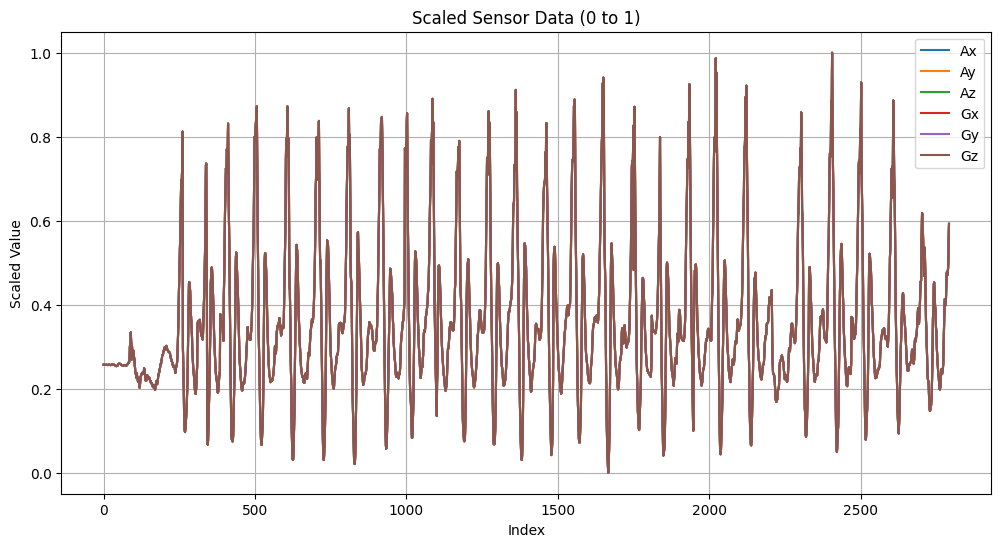

In [10]:
plt.figure(figsize=(12, 6))
# Plot each column
for column in scaled_df.columns:
    plt.plot(scaled_df.index, scaled_df['Ax'], linestyle='-', label=column)

# Add title and labels
plt.title('Scaled Sensor Data (0 to 1)')
plt.xlabel('Index')
plt.ylabel('Scaled Value')

# Add a legend to distinguish the lines
plt.legend()

# Add a grid for better readability
plt.grid(True)

# Show the plot
plt.show()

Successfully loaded signal from column 'Ax'. Length: 2792 samples.

Attempting peak detection on 'Ax' with parameters:
  - Min Height: 0.41
  - Min Distance: 24
  - Min Prominence: 0.18
Initially detected 48 peaks in 'Ax'.
More than 27 peaks found. Filtering by prominence...
Selected 27 most prominent peaks.

Segmenting data with window: 34 points before peak, 68 points after peak.
Successfully created 27 segments.
Example: First segment shape: (103, 6)


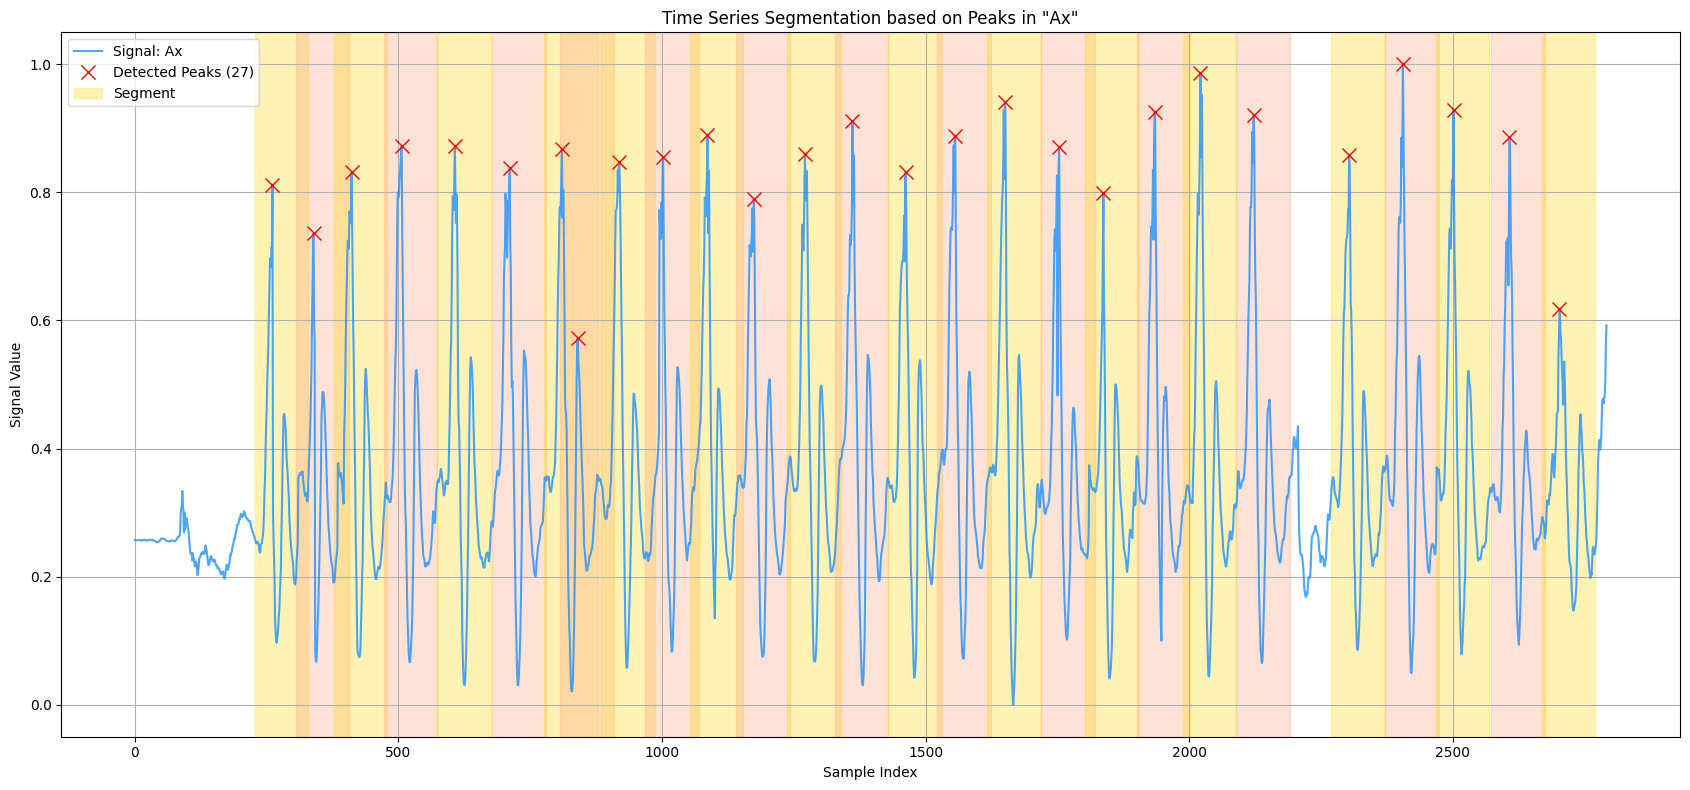


Found 27 swing segments.

Data for the first detected swing (first 5 rows):
           Ax        Ay        Az        Gx        Gy        Gz
227  0.261477  0.791209  0.399435  0.408316  0.518364  0.558038
228  0.258208  0.789346  0.394728  0.418845  0.520333  0.548135
229  0.254940  0.784628  0.385561  0.426230  0.519356  0.541115
230  0.251969  0.780096  0.375304  0.427558  0.516594  0.539422
231  0.252117  0.776060  0.372281  0.418112  0.501518  0.544320


In [11]:
# --- Configuration ---
TARGET_COLUMN_NAME = 'Ax' # The column in your DataFrame to analyze for peaks
EXPECTED_NUM_SWINGS = 27    # The number of swings you expect to find

# --- Function Definitions ---

def load_and_prepare_signal(dataframe: pd.DataFrame, column_name: str):
    if column_name not in dataframe.columns:
        print(f"Error: Column '{column_name}' not found in the DataFrame.")
        print(f"Available columns are: {dataframe.columns.tolist()}")
        return None, None

    signal_array = dataframe[column_name].to_numpy()
    time_index = np.arange(len(signal_array))
    print(f"Successfully loaded signal from column '{column_name}'. Length: {len(signal_array)} samples.")
    return signal_array, time_index


def detect_swing_peaks(signal_array, num_expected_swings, column_name_for_print="signal"):
    """
    Detects peaks in the signal, attempting to find the specified number of swings.

    Args:
        signal_array (np.ndarray): The input signal.
        num_expected_swings (int): The desired number of peaks (swings).
        column_name_for_print (str): Name of the signal column for printing messages.


    Returns:
        np.ndarray: An array of indices for the detected peaks. Returns empty array if issues.
    """
    if signal_array is None or len(signal_array) == 0:
        print("Error: Signal array is empty or None. Cannot detect peaks.")
        return np.array([])

    # --- Tune these peak detection parameters carefully! ---
    median_val = np.median(signal_array)
    std_val = np.std(signal_array)

    # Initial sensible defaults - these almost ALWAYS need tuning for specific data
    peak_height_param = median_val + std_val * 0.5  # Example: 1 standard deviation above median
    # Ensure distance is at least 1
    peak_distance_param = max(1, len(signal_array) // (num_expected_swings + 85)) # Heuristic
    peak_prominence_param = std_val * 1 # Example: half a standard deviation

    print(f"\nAttempting peak detection on '{column_name_for_print}' with parameters:")
    print(f"  - Min Height: {peak_height_param:.2f}")
    print(f"  - Min Distance: {peak_distance_param}")
    print(f"  - Min Prominence: {peak_prominence_param:.2f}")

    detected_indices, properties = find_peaks(
        signal_array,
        height=peak_height_param,
        distance=peak_distance_param,
        prominence=peak_prominence_param
    )
    print(f"Initially detected {len(detected_indices)} peaks in '{column_name_for_print}'.")

    final_peak_indices = detected_indices

    if len(detected_indices) == 0:
        print(f"No peaks detected in '{column_name_for_print}' with current parameters. Try adjusting them.")
        return np.array([])
    elif len(detected_indices) > num_expected_swings:
        print(f"More than {num_expected_swings} peaks found. Filtering by prominence...")
        if 'prominences' in properties and properties['prominences'] is not None and len(properties['prominences']) > 0:
            prominences = properties['prominences']
            most_prominent_sorted_indices = np.argsort(prominences)[::-1][:num_expected_swings]
            final_peak_indices = np.sort(detected_indices[most_prominent_sorted_indices])
            print(f"Selected {len(final_peak_indices)} most prominent peaks.")
        else:
            print("Prominence data not available for filtering. Using the first N detected peaks as a fallback.")
            final_peak_indices = detected_indices[:num_expected_swings]
    elif len(detected_indices) < num_expected_swings:
        print(f"Fewer than {num_expected_swings} peaks found ({len(detected_indices)}).")
        print("Consider adjusting peak detection parameters (e.g., lower height/prominence, smaller distance).")
        # We'll proceed with the peaks found.
    else:
        print(f"Successfully detected {len(detected_indices)} peaks, matching expected number.")

    return final_peak_indices


def segment_data_around_peaks(full_dataframe, peak_indices, num_expected_segments):
    """
    Segments the full DataFrame around the detected peak indices.

    Args:
        full_dataframe (pd.DataFrame): The original DataFrame containing all data.
        peak_indices (np.ndarray): Indices of the detected peaks.
        num_expected_segments (int): Expected number of segments (swings). Used to estimate window.

    Returns:
        list: A list of DataFrames, where each DataFrame is a segment.
    """
    segmented_dataframes = []
    if peak_indices is None or len(peak_indices) == 0:
        print("No peak indices provided for segmentation.")
        return segmented_dataframes

    # --- Define window for segmentation ---
    # This is a heuristic. You might need a more sophisticated way or fixed values.
    if num_expected_segments > 0 and len(full_dataframe) > 0 :
        points_per_segment_approx = len(full_dataframe) // num_expected_segments
    else:
        points_per_segment_approx = 50 # Default if no segments or data to estimate

    # Adjust these based on your swing characteristics (how much data before/after peak)
    points_before_peak = points_per_segment_approx // 3
    points_after_peak = (points_per_segment_approx * 2) // 3

    print(f"\nSegmenting data with window: {points_before_peak} points before peak, {points_after_peak} points after peak.")

    for peak_idx in peak_indices:
        start_idx = max(0, peak_idx - points_before_peak)
        # +1 to make slicing inclusive of the end_idx if pandas.iloc is used
        end_idx = min(len(full_dataframe), peak_idx + points_after_peak + 1)

        segment_df = full_dataframe.iloc[start_idx:end_idx].copy()
        segmented_dataframes.append(segment_df)

    print(f"Successfully created {len(segmented_dataframes)} segments.")
    if segmented_dataframes:
        print(f"Example: First segment shape: {segmented_dataframes[0].shape}")
    return segmented_dataframes


def plot_segmentation_results(signal_array, time_index, peak_indices, segmented_dataframes, column_name):
    """
    Plots the original signal, detected peaks, and segmented regions.

    Args:
        signal_array (np.ndarray): The signal that was analyzed.
        time_index (np.ndarray): The time/sample index for the signal.
        peak_indices (np.ndarray): Indices of the detected peaks.
        segmented_dataframes (list): List of DataFrames, each being a segment.
        column_name (str): Name of the signal column for plot title.
    """
    if signal_array is None or time_index is None:
        print("Cannot plot: Signal or time index is missing.")
        return

    plt.figure(figsize=(17, 8))
    plt.plot(time_index, signal_array, label=f'Signal: {column_name}', alpha=0.8, color='dodgerblue')

    if peak_indices is not None and len(peak_indices) > 0:
        plt.plot(time_index[peak_indices], signal_array[peak_indices], "x", color='red', markersize=10, label=f'Detected Peaks ({len(peak_indices)})')

        # Shade segmented regions
        # Need to reconstruct window parameters or pass them if they differ from segmentation
        # For simplicity, let's assume segments in `segmented_dataframes` directly map to plotted regions
        for i, segment_df in enumerate(segmented_dataframes):
            if not segment_df.empty:
                start_plot_idx = segment_df.index[0]
                end_plot_idx = segment_df.index[-1]
                plt.axvspan(start_plot_idx, end_plot_idx,
                            color='gold' if i % 2 == 0 else 'lightsalmon',
                            alpha=0.3, label='Segment' if i == 0 else None)

    plt.title(f'Time Series Segmentation based on Peaks in "{column_name}"')
    plt.xlabel('Sample Index')
    plt.ylabel('Signal Value')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


# --- Main Execution ---
if __name__ == "__main__":
    # **IMPORTANT**: Load your 'scaled_data' DataFrame here first!
    # Example:
    # scaled_data = pd.read_csv('path_to_your_data.csv')

    # 1. Load and Prepare Data
    # Make sure your `scaled_data` DataFrame is loaded before this line!
    ax_signal, R_time_index = load_and_prepare_signal(scaled_df, TARGET_COLUMN_NAME)

    if ax_signal is not None:
        # 2. Detect Peaks
        R_peak_indices = detect_swing_peaks(ax_signal, EXPECTED_NUM_SWINGS, TARGET_COLUMN_NAME)

        # 3. Segment Data
        # Pass the original `scaled_data` for segmentation to include all columns.
        R_list_of_swing_dataframes = segment_data_around_peaks(scaled_df, R_peak_indices, EXPECTED_NUM_SWINGS)

        # 4. Plot Results
        plot_segmentation_results(ax_signal, R_time_index, R_peak_indices, R_list_of_swing_dataframes, TARGET_COLUMN_NAME)

        # You can now work with `R_list_of_swing_dataframes`
        if R_list_of_swing_dataframes:
            print(f"\nFound {len(R_list_of_swing_dataframes)} swing segments.")
            # Example: Access the first swing's data
            first_swing_data = R_list_of_swing_dataframes[0]
            print("\nData for the first detected swing (first 5 rows):")
            print(first_swing_data.head())
        else:
            print("\nNo swing segments were created.")
    else:
        print("Could not proceed due to issues loading the signal.")

Successfully loaded signal from column 'Ax'. Length: 2792 samples.

Attempting peak detection on 'Ax' with parameters:
  - Min Height: 0.41
  - Min Distance: 24
  - Min Prominence: 0.18
Initially detected 48 peaks in 'Ax'.
More than 27 peaks found. Filtering by prominence...
Selected 27 most prominent peaks.

Segmenting data with window: 34 points before peak, 68 points after peak.
Successfully created 27 segments.
Example: First segment shape: (103, 6)


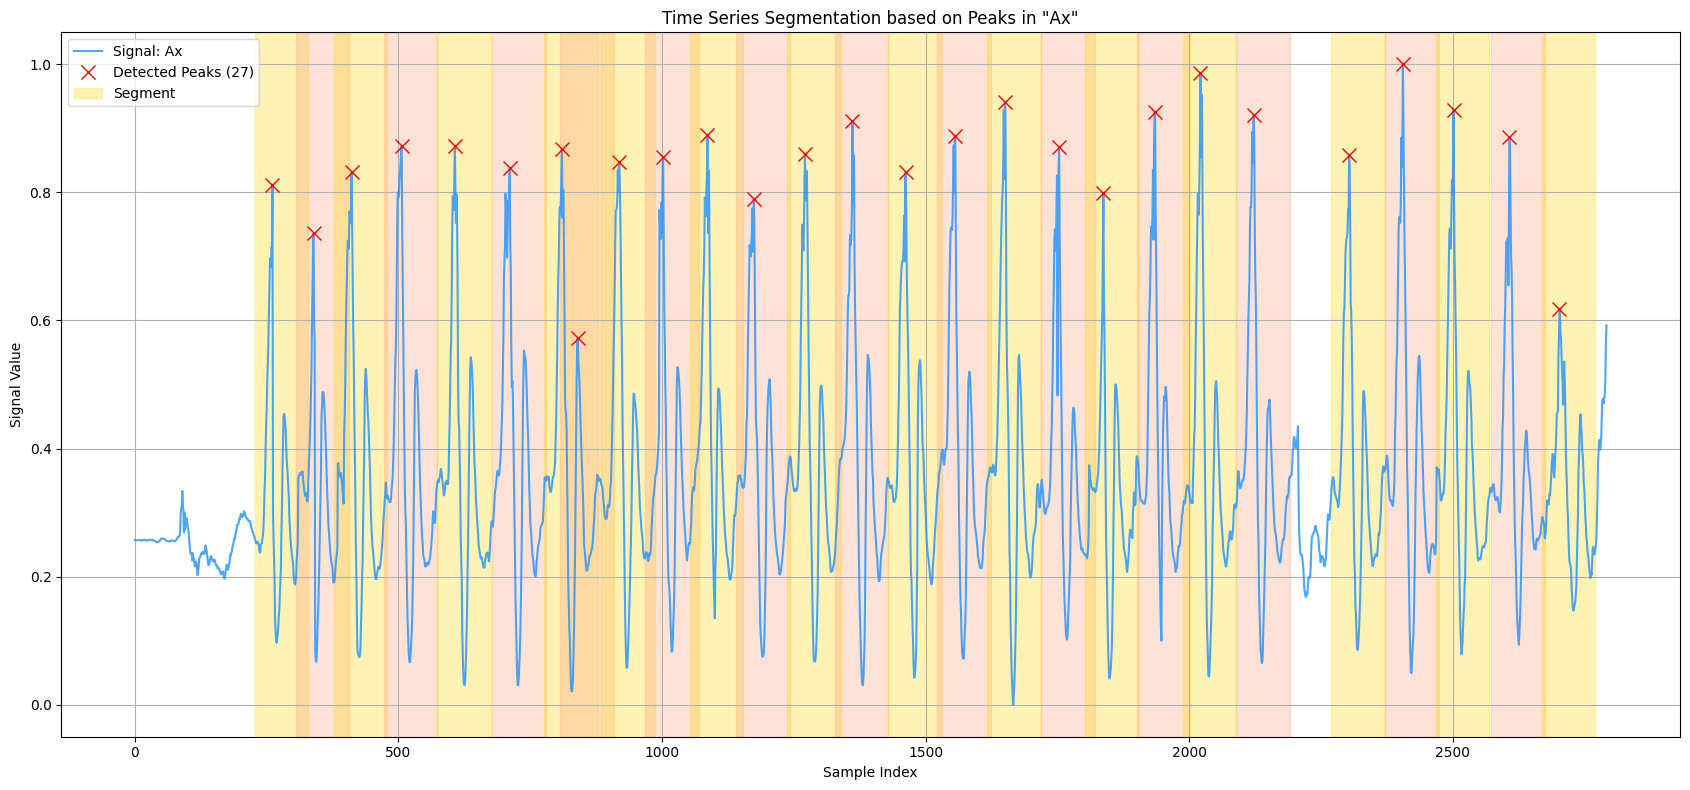


Generating individual plots for 27 swing segments...


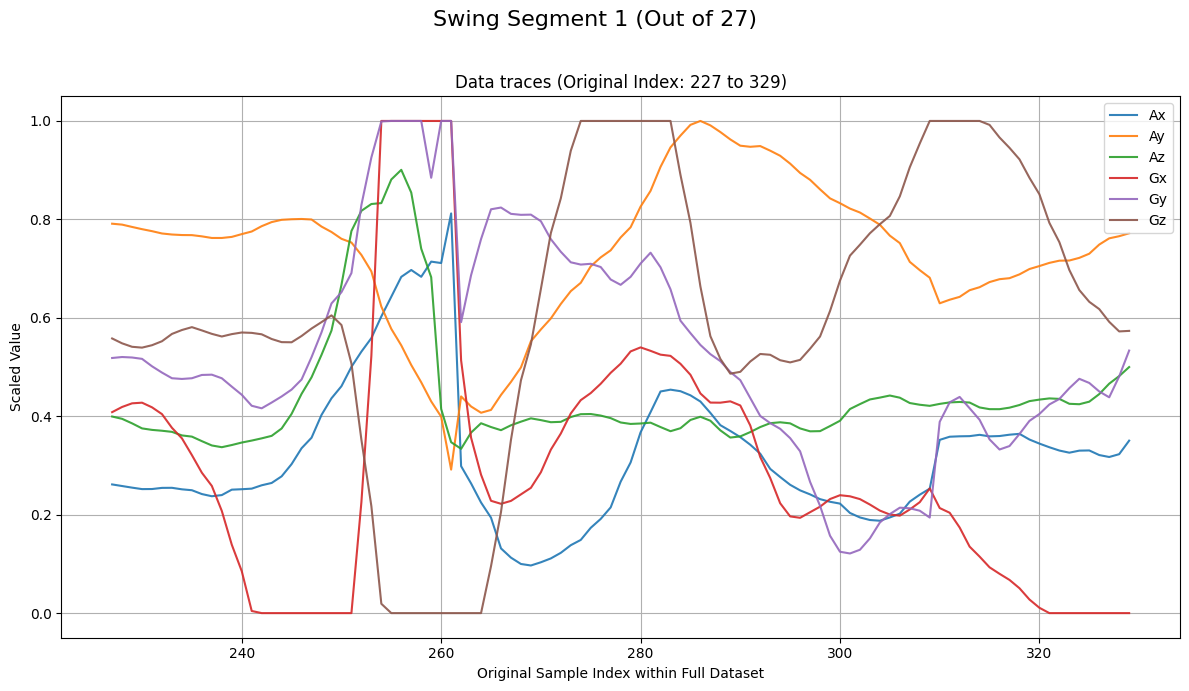

Plotted segment 1. Close plot window to see the next one (if applicable).


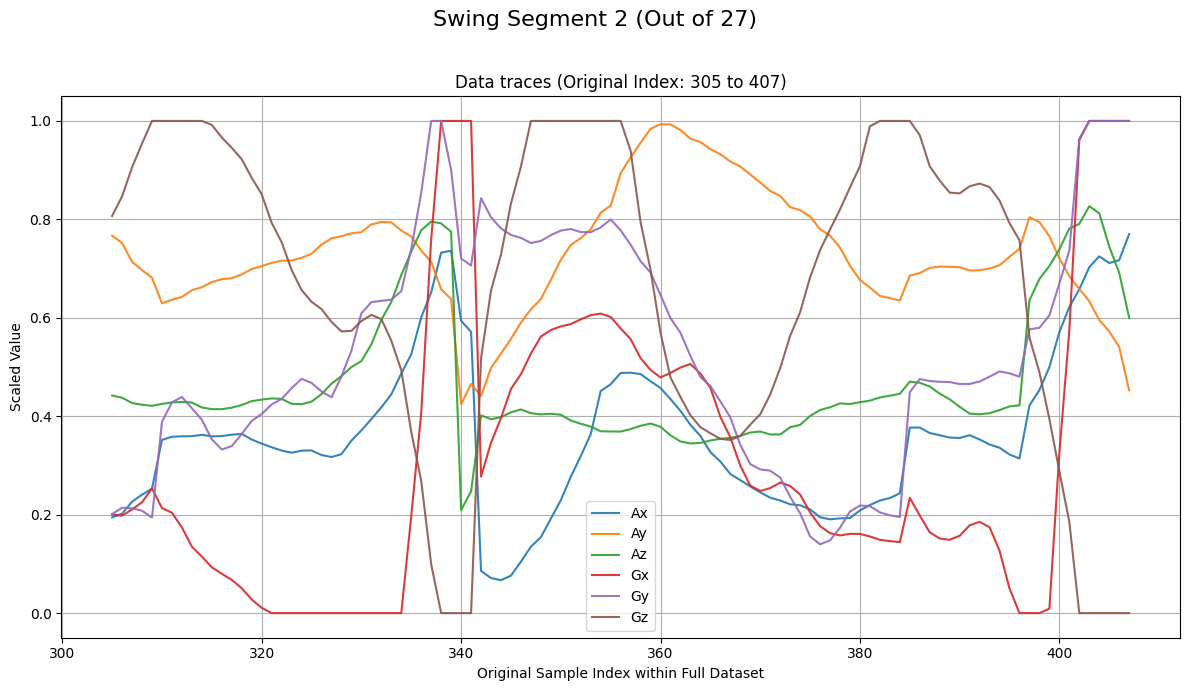

Plotted segment 2. Close plot window to see the next one (if applicable).


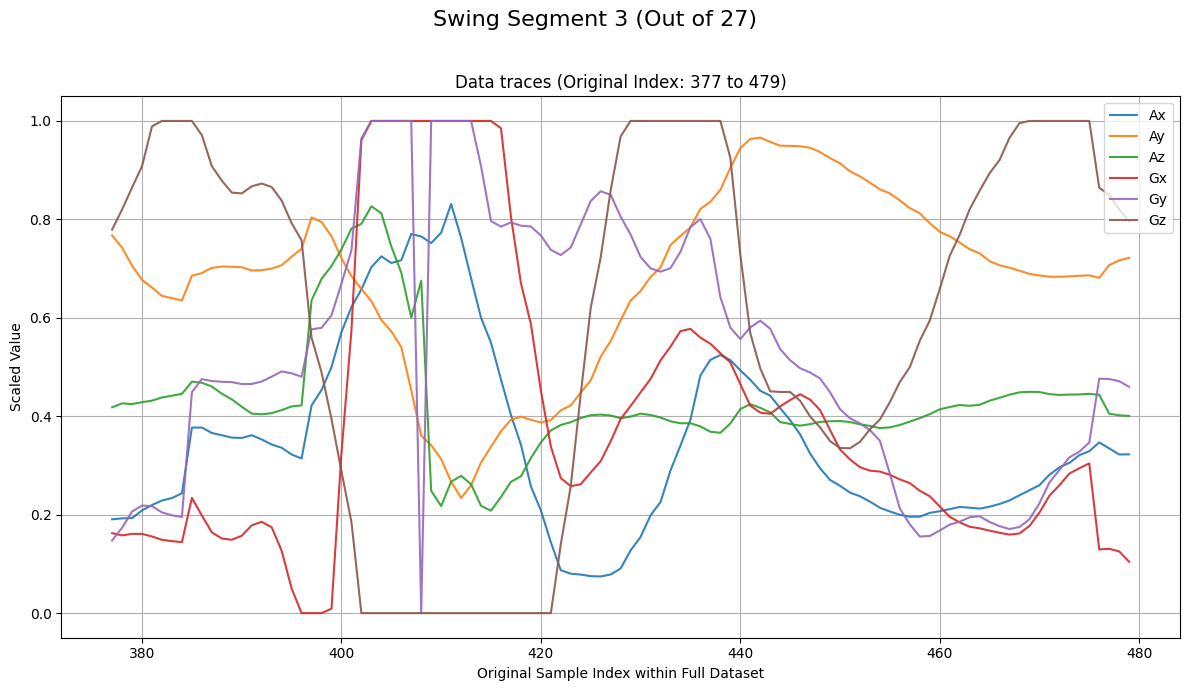

Plotted segment 3. Close plot window to see the next one (if applicable).


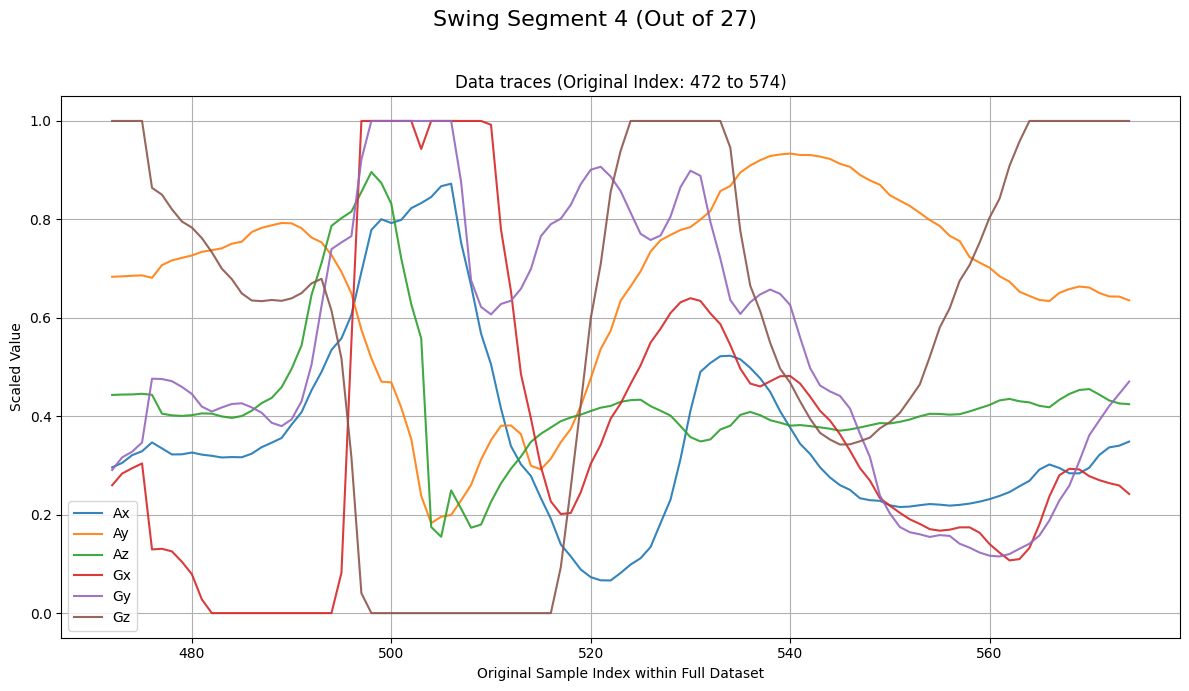

Plotted segment 4. Close plot window to see the next one (if applicable).


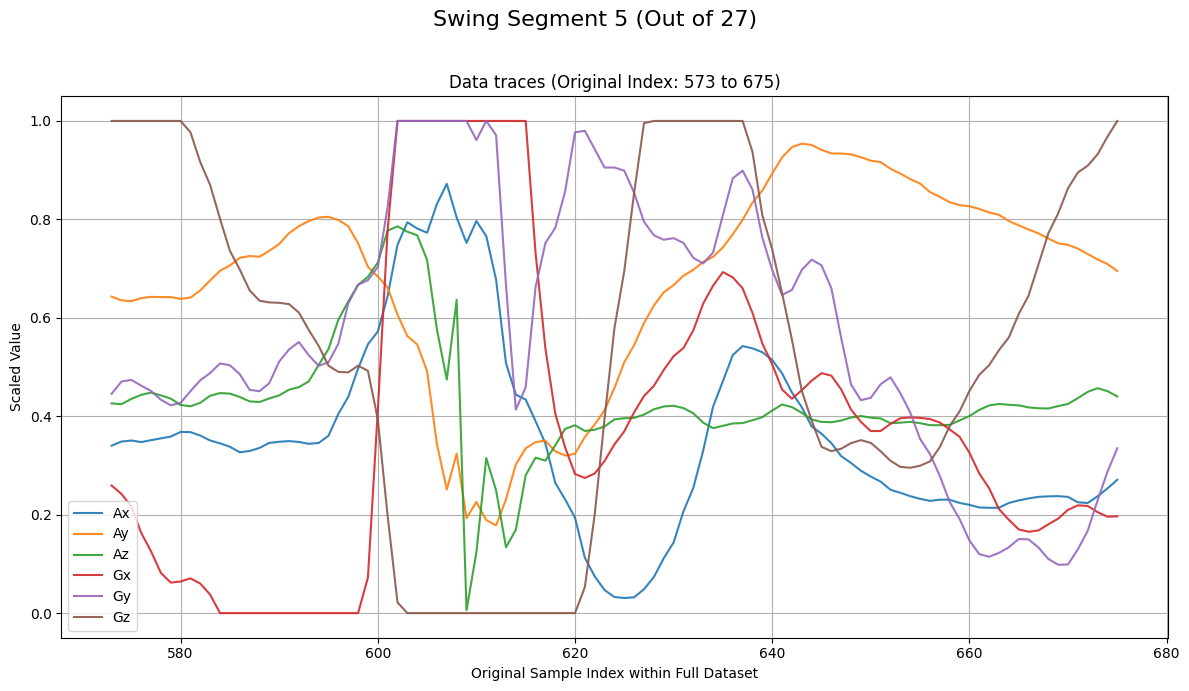

Plotted segment 5. Close plot window to see the next one (if applicable).


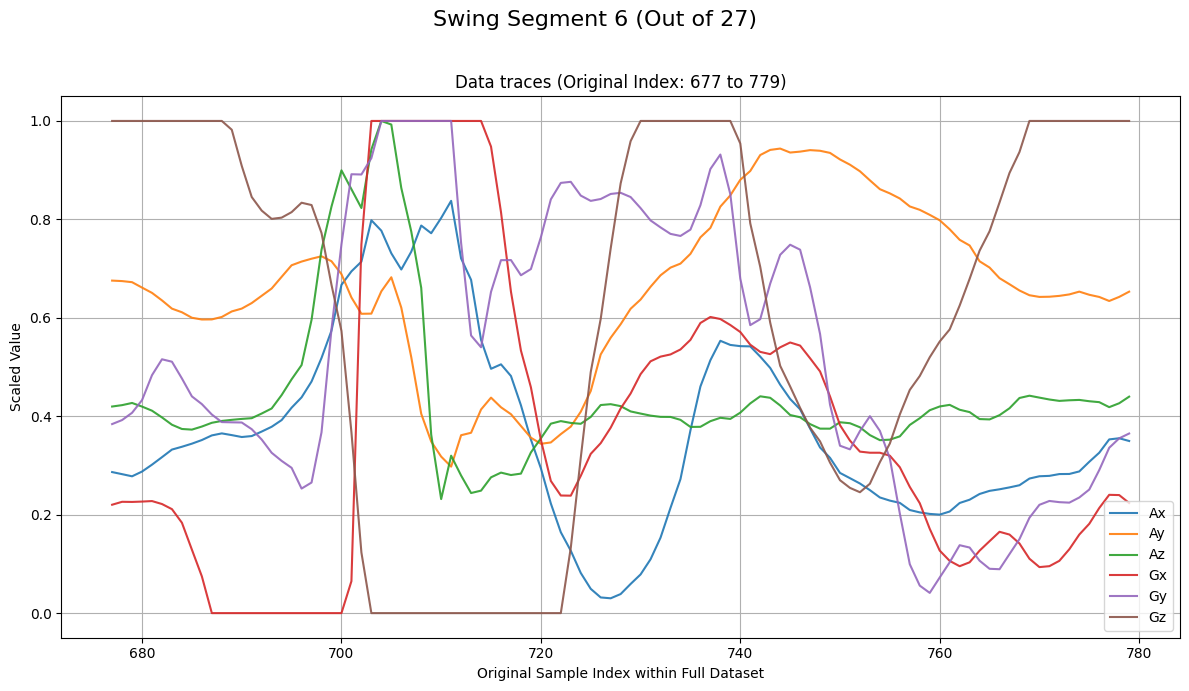

Plotted segment 6. Close plot window to see the next one (if applicable).


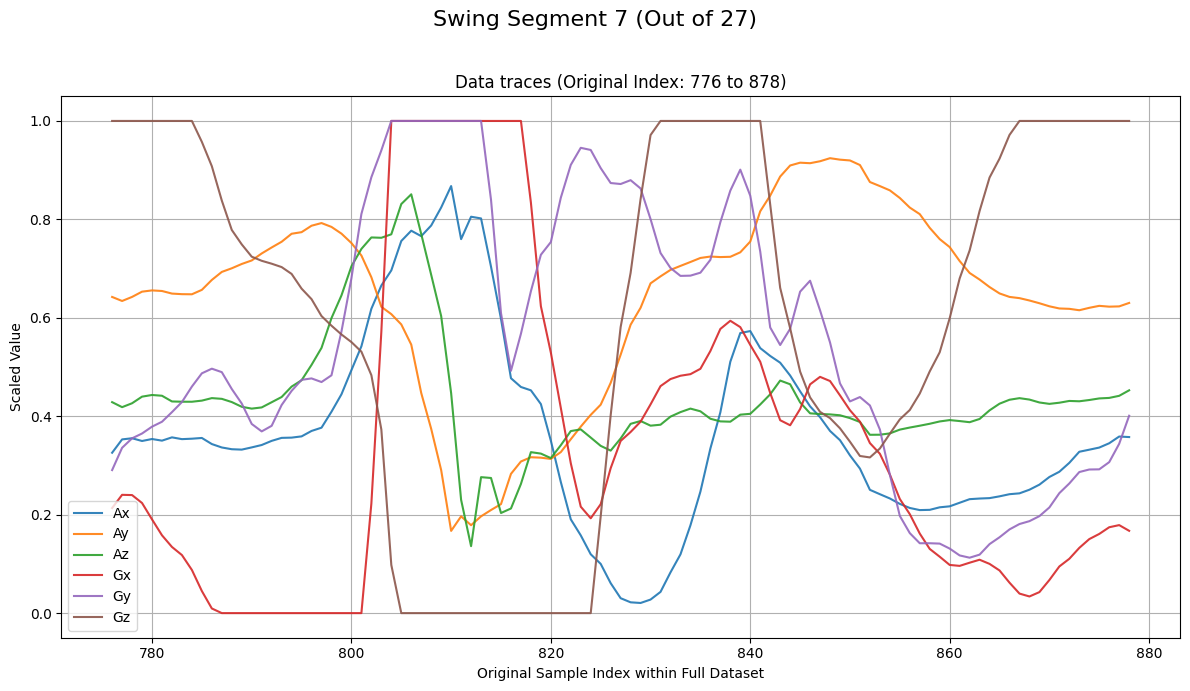

Plotted segment 7. Close plot window to see the next one (if applicable).


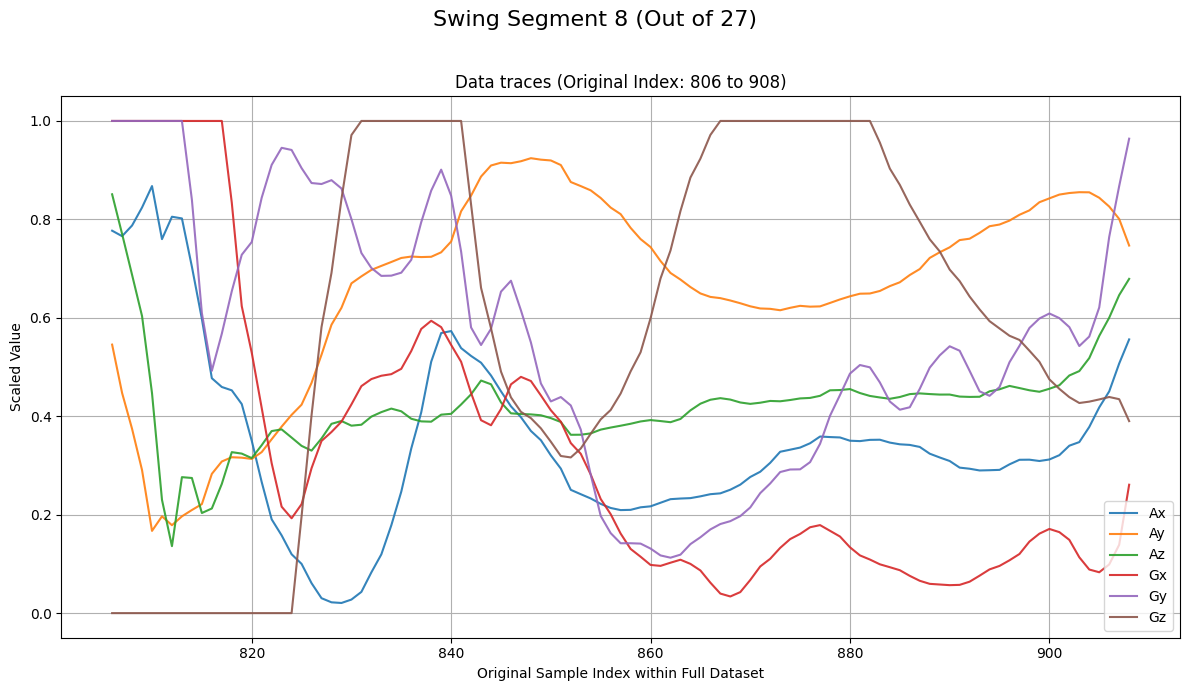

Plotted segment 8. Close plot window to see the next one (if applicable).


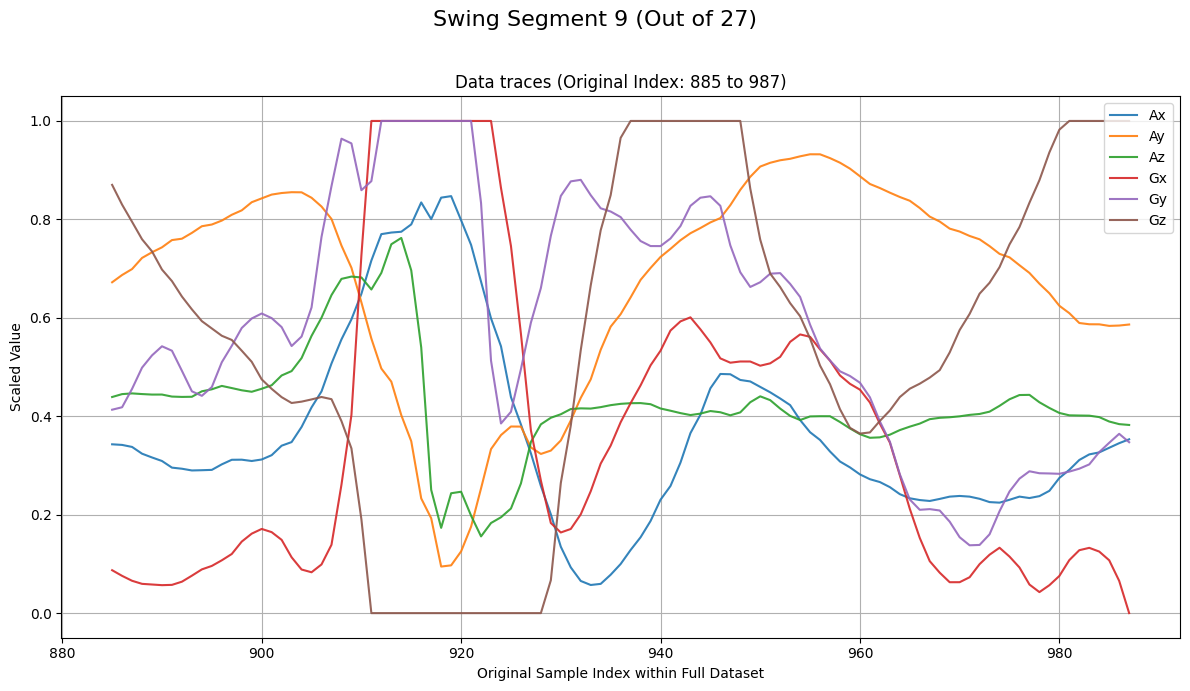

Plotted segment 9. Close plot window to see the next one (if applicable).


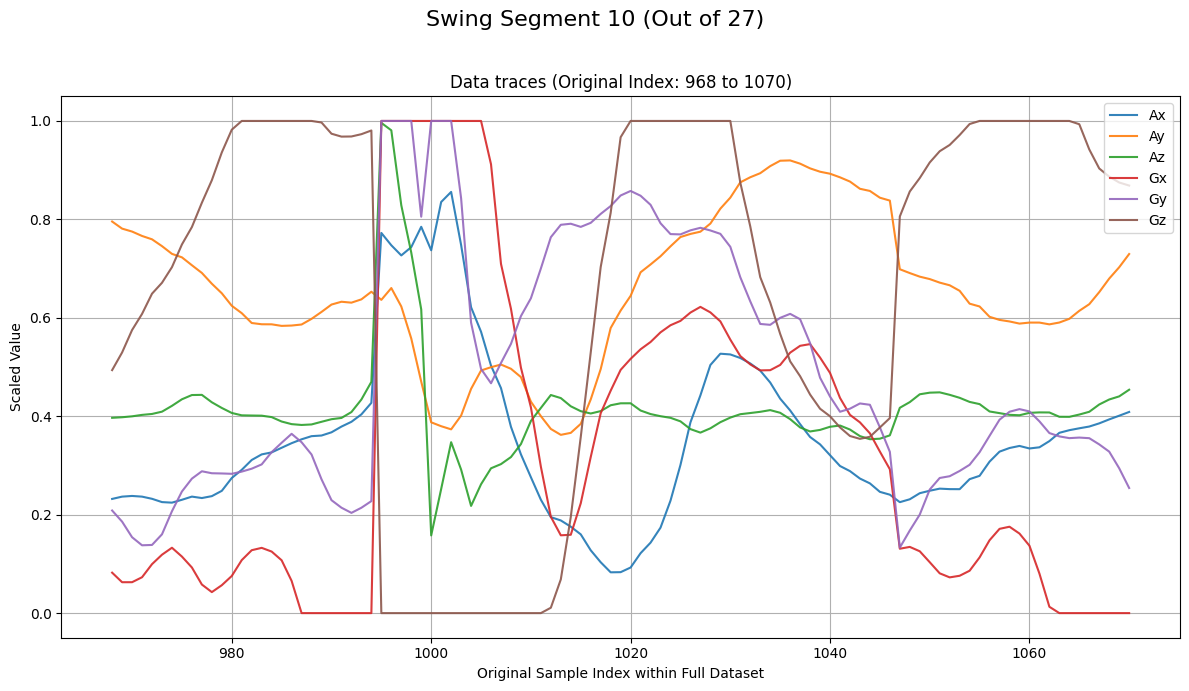

Plotted segment 10. Close plot window to see the next one (if applicable).


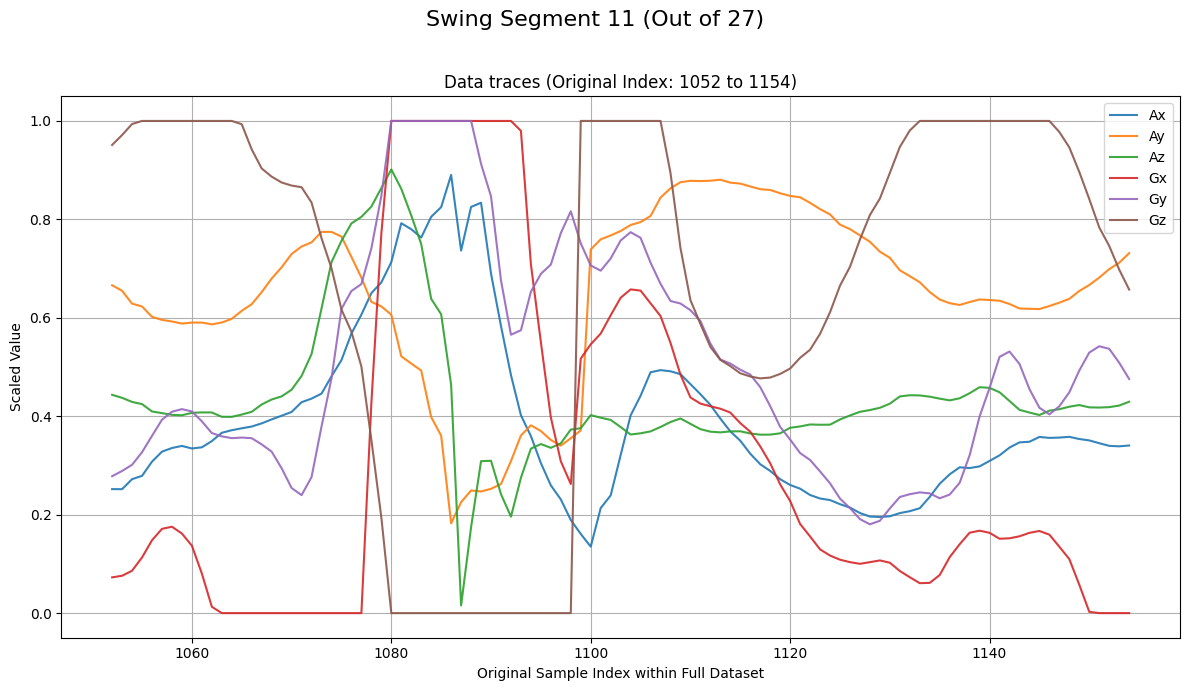

Plotted segment 11. Close plot window to see the next one (if applicable).


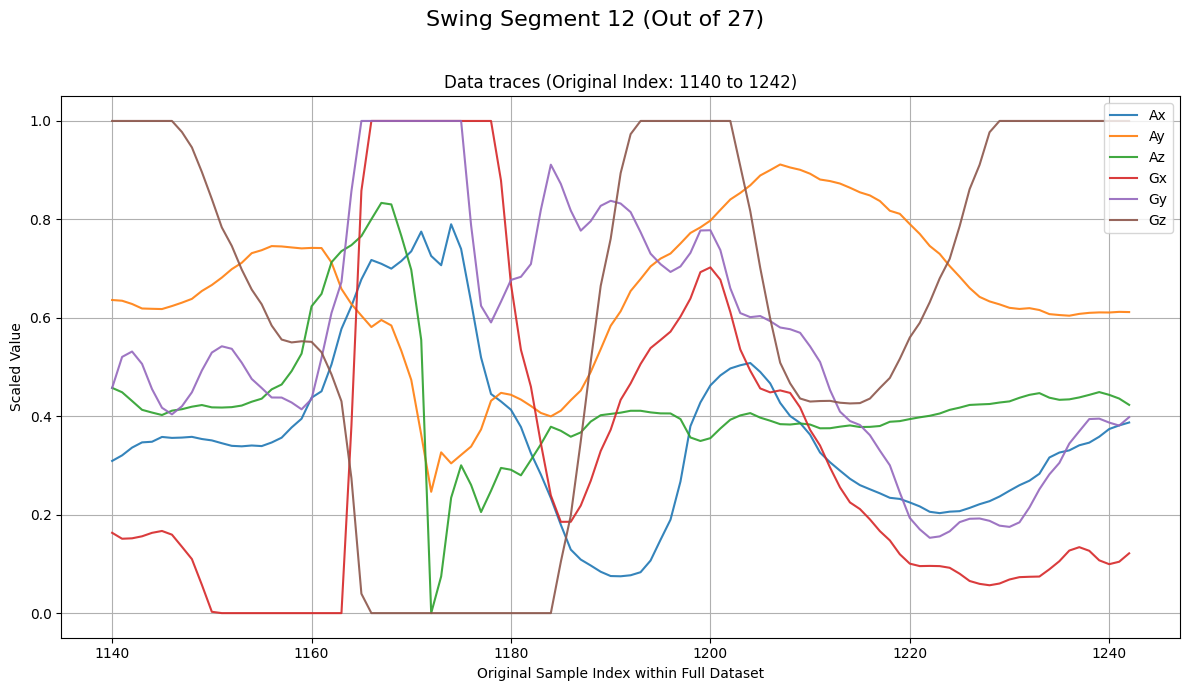

Plotted segment 12. Close plot window to see the next one (if applicable).


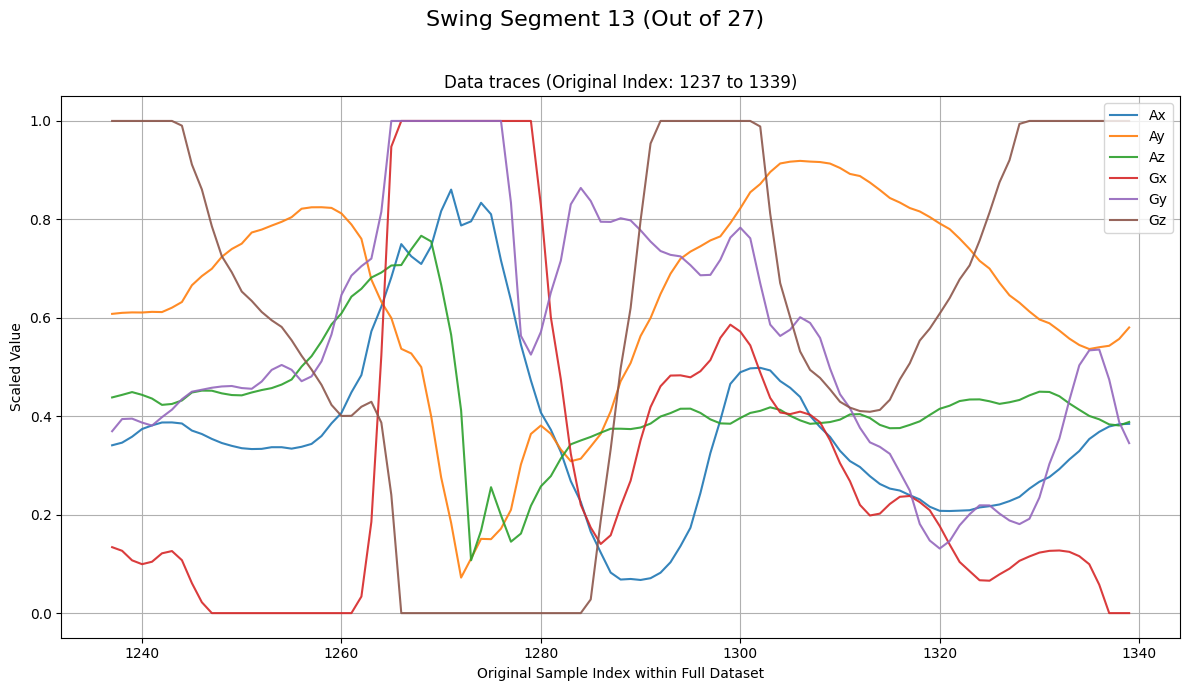

Plotted segment 13. Close plot window to see the next one (if applicable).


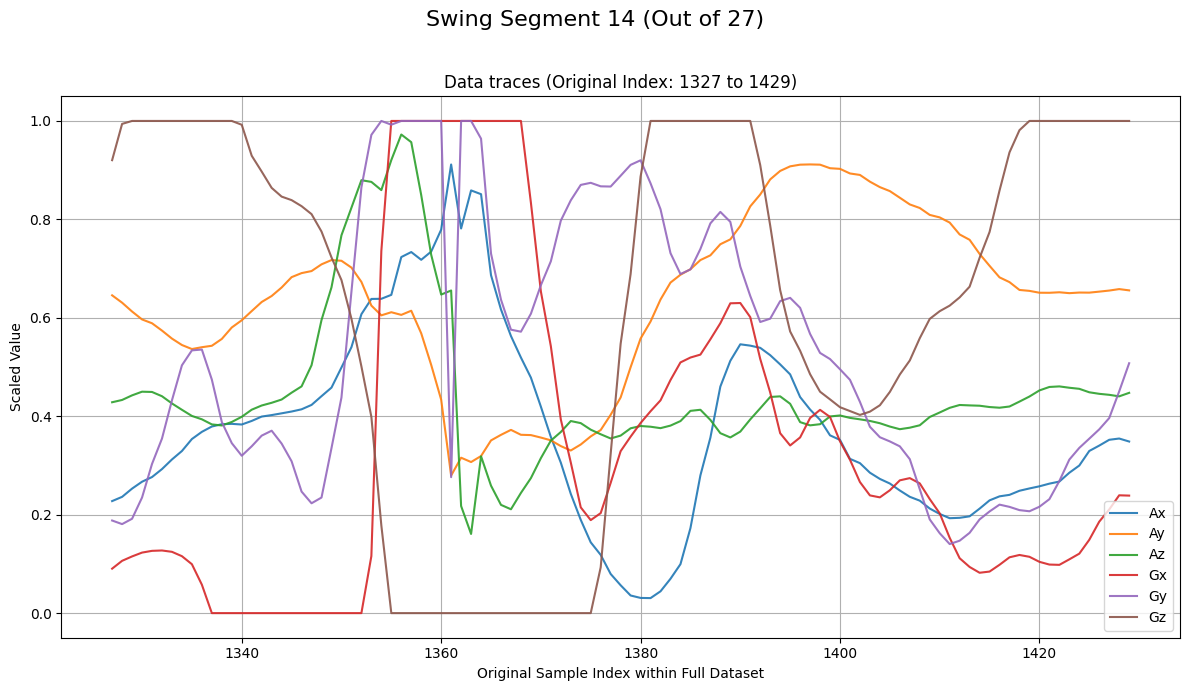

Plotted segment 14. Close plot window to see the next one (if applicable).


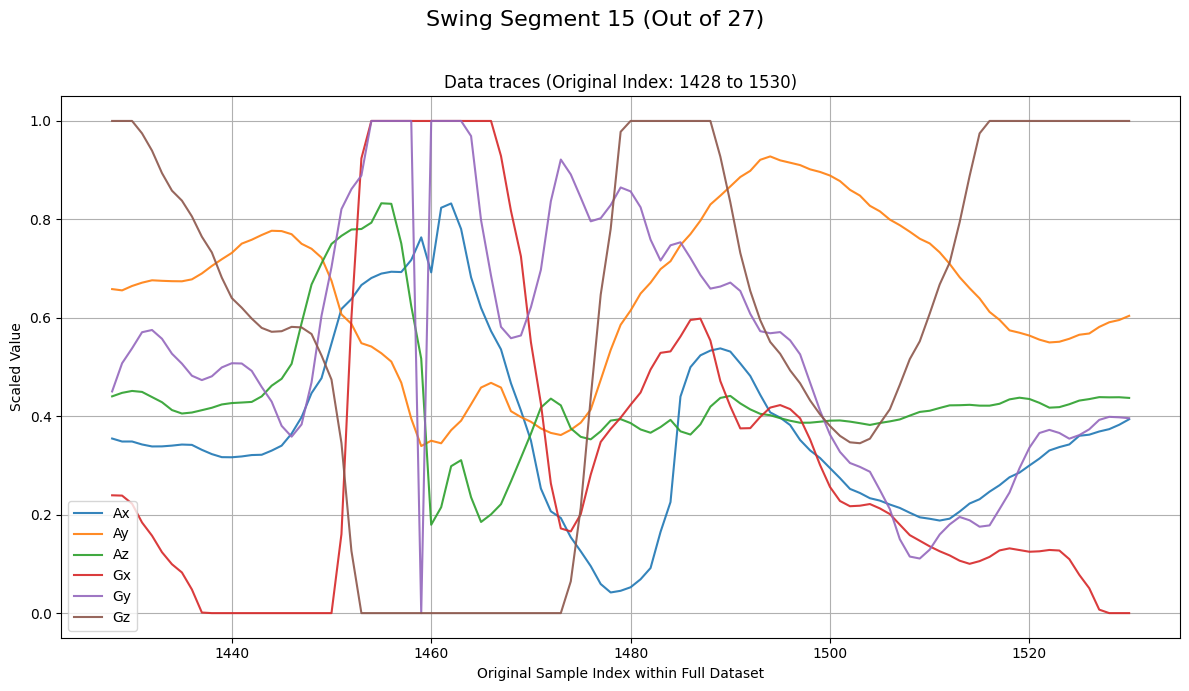

Plotted segment 15. Close plot window to see the next one (if applicable).


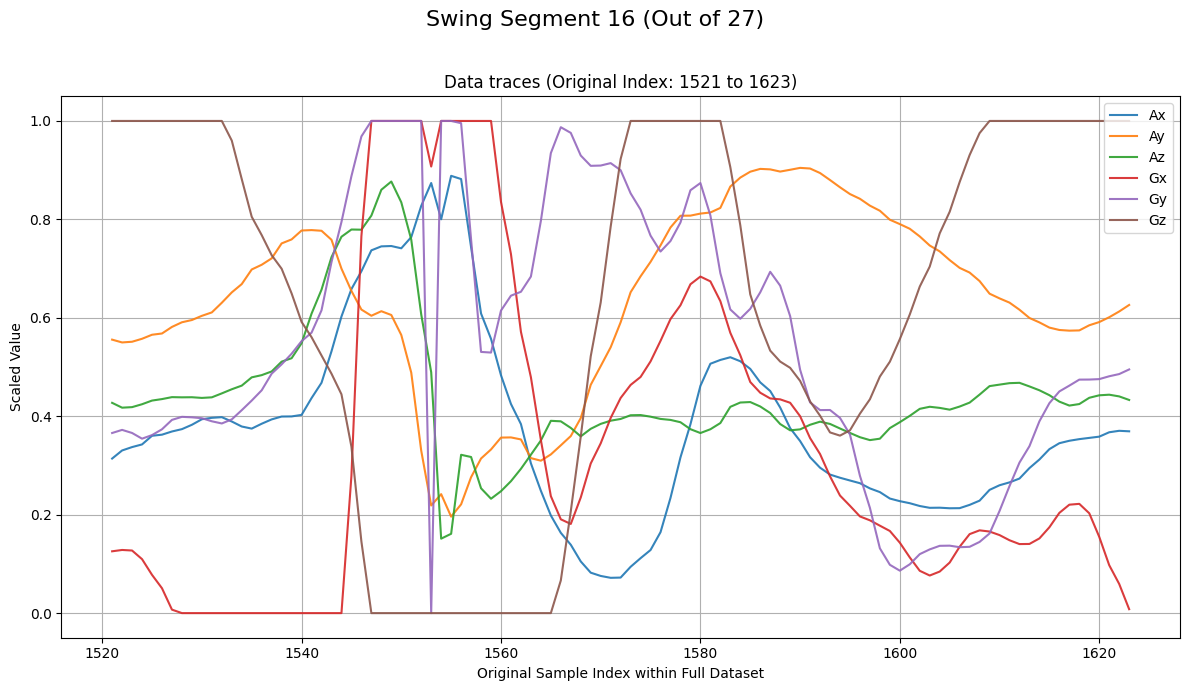

Plotted segment 16. Close plot window to see the next one (if applicable).


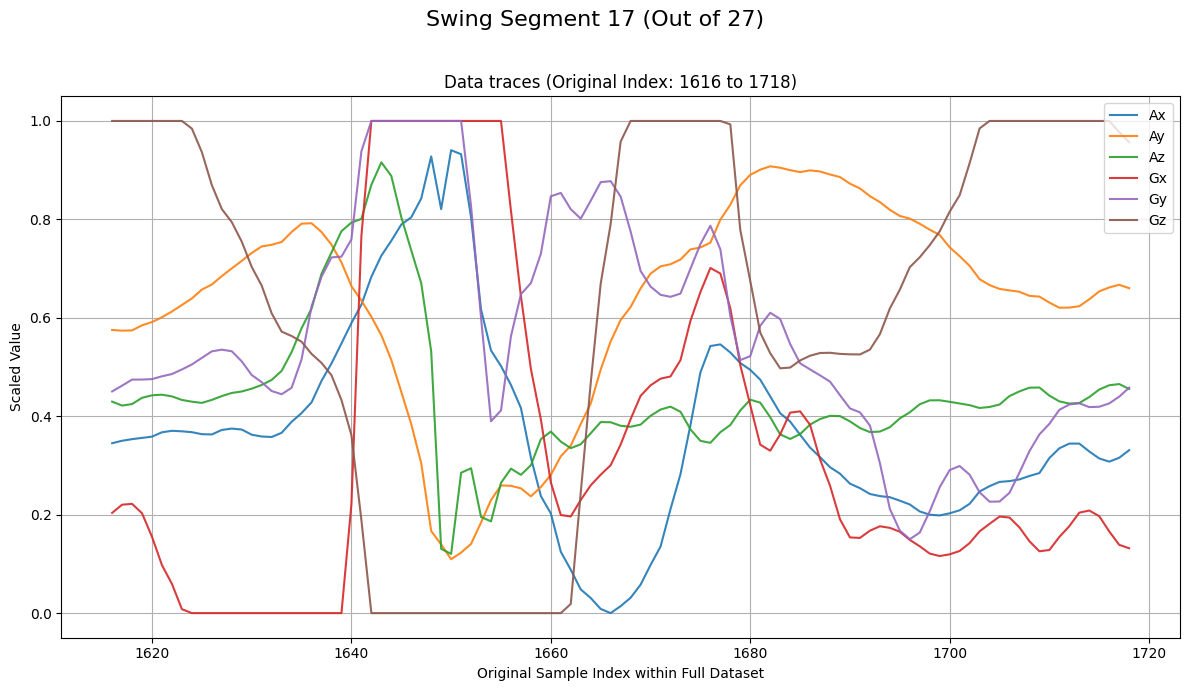

Plotted segment 17. Close plot window to see the next one (if applicable).


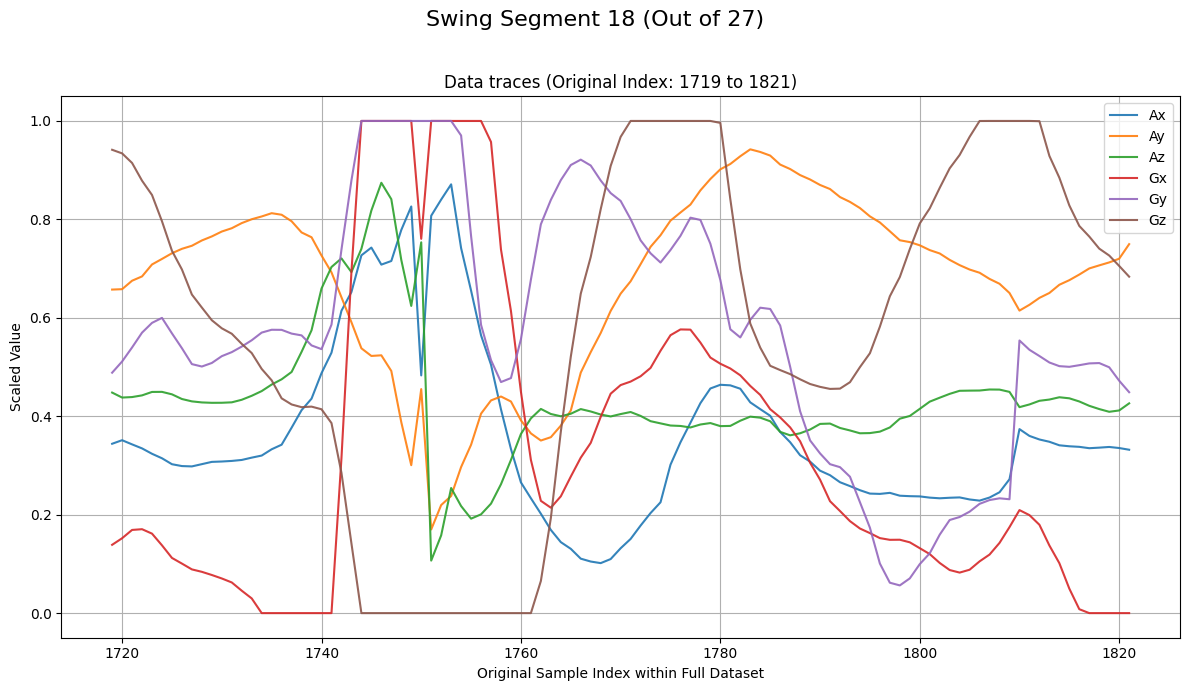

Plotted segment 18. Close plot window to see the next one (if applicable).


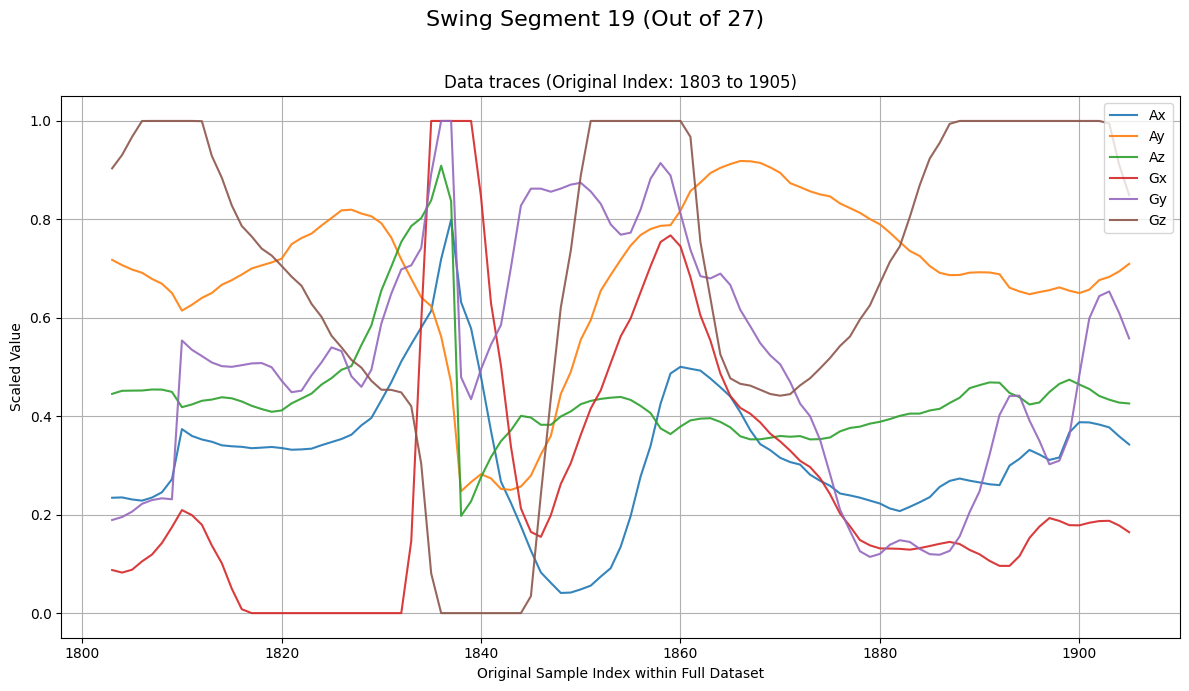

Plotted segment 19. Close plot window to see the next one (if applicable).


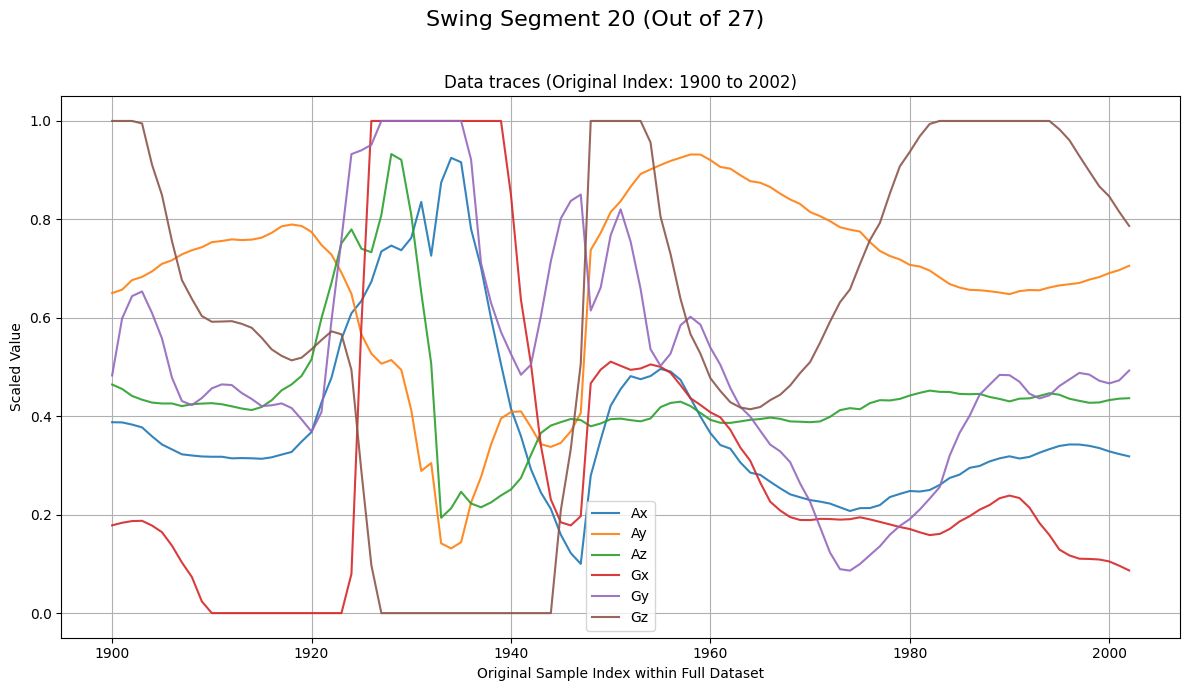

Plotted segment 20. Close plot window to see the next one (if applicable).


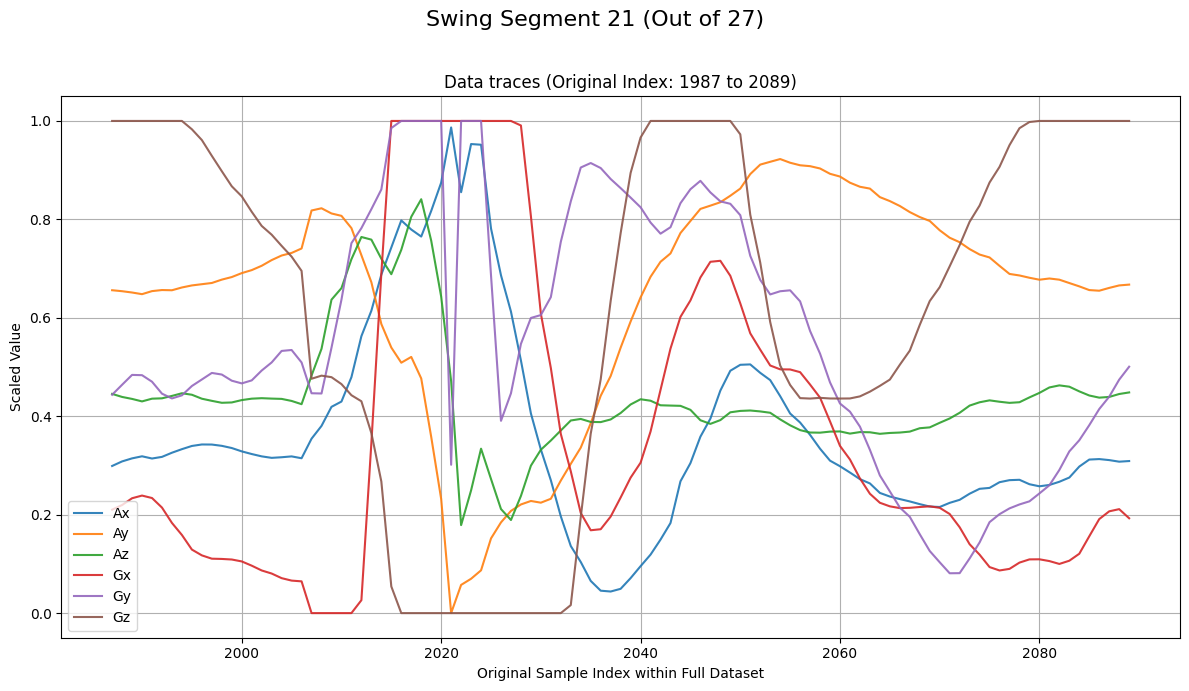

Plotted segment 21. Close plot window to see the next one (if applicable).


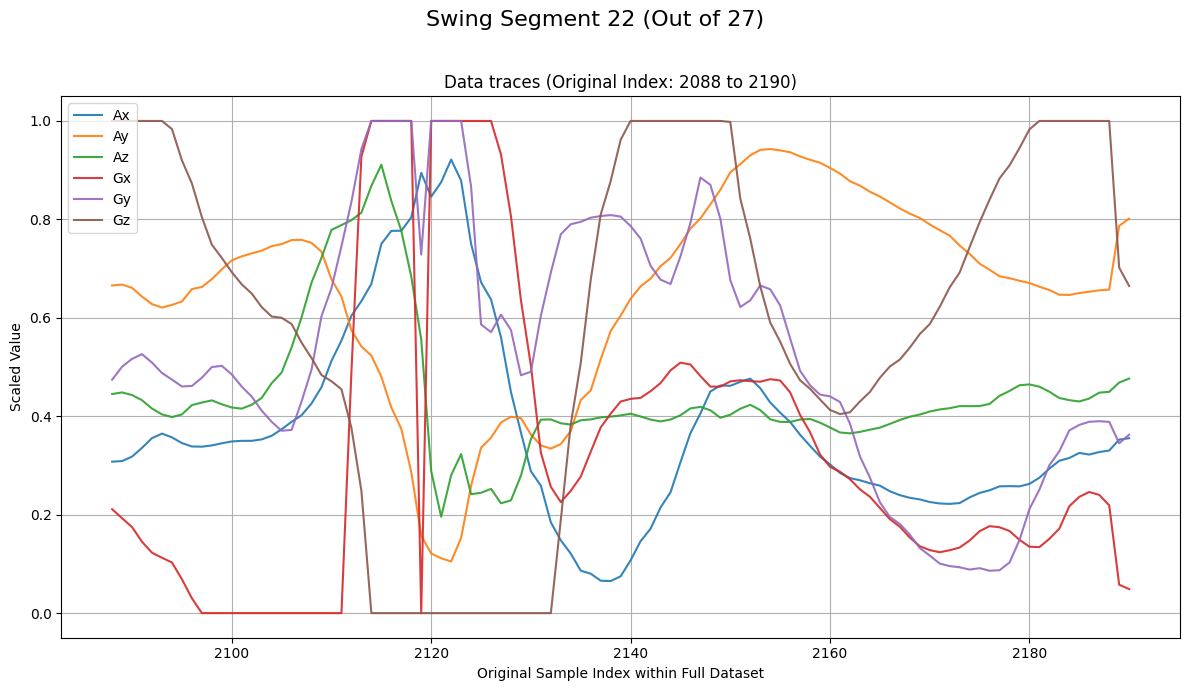

Plotted segment 22. Close plot window to see the next one (if applicable).


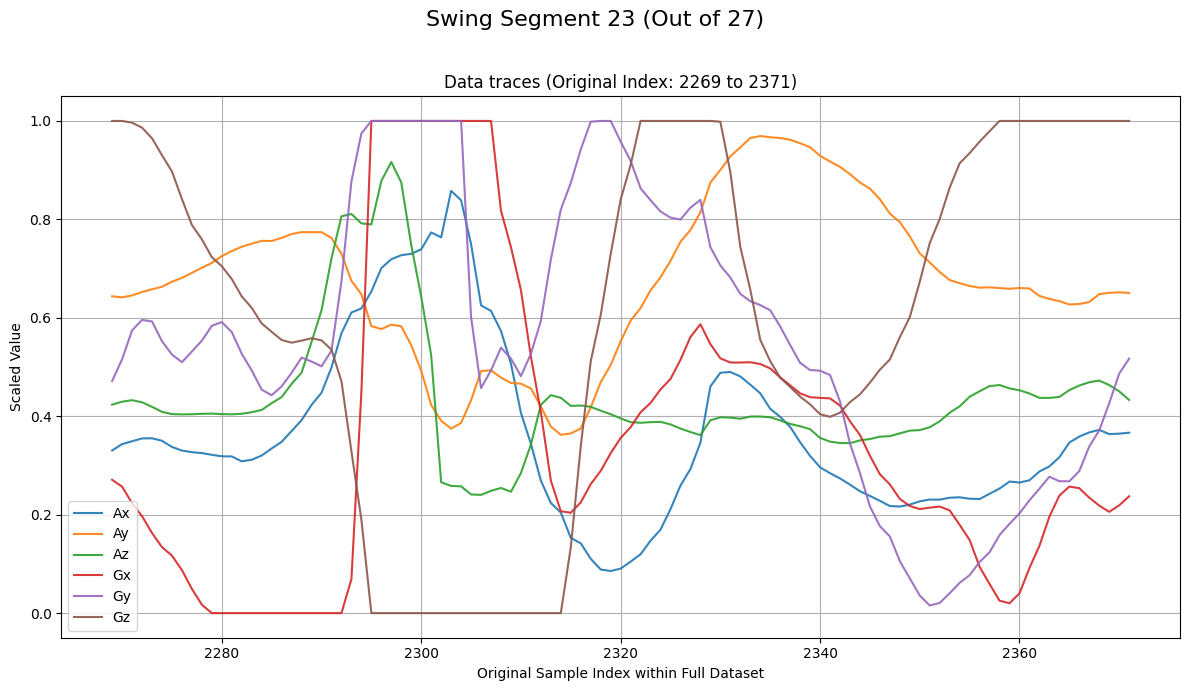

Plotted segment 23. Close plot window to see the next one (if applicable).


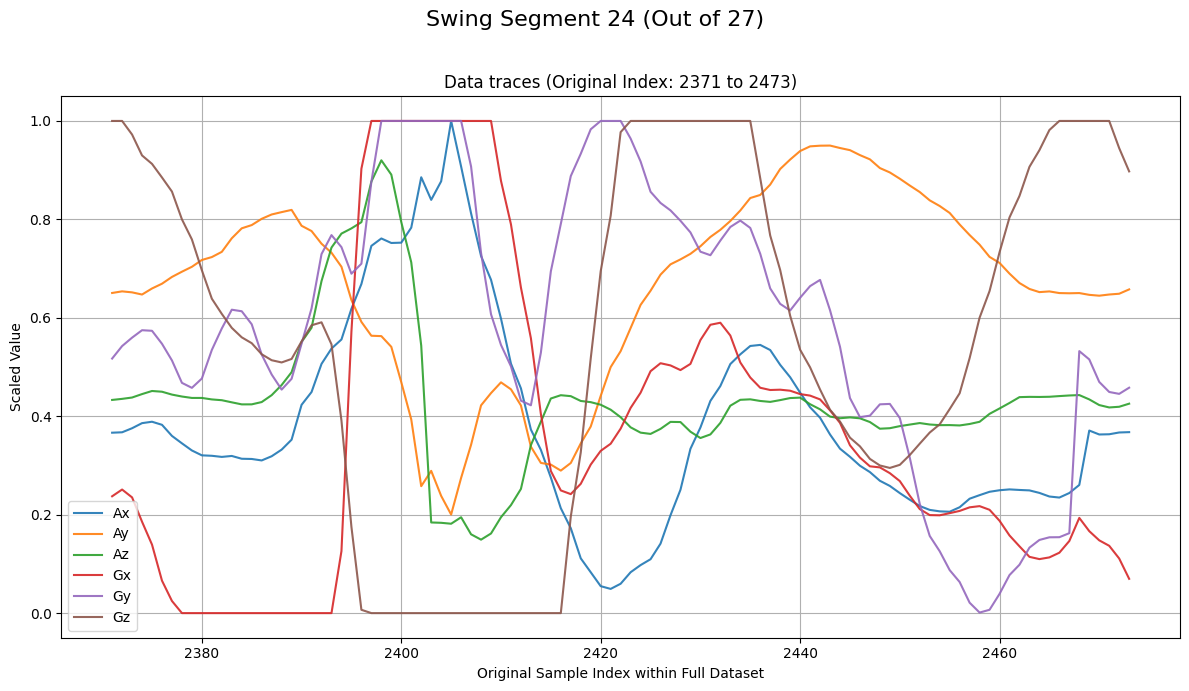

Plotted segment 24. Close plot window to see the next one (if applicable).


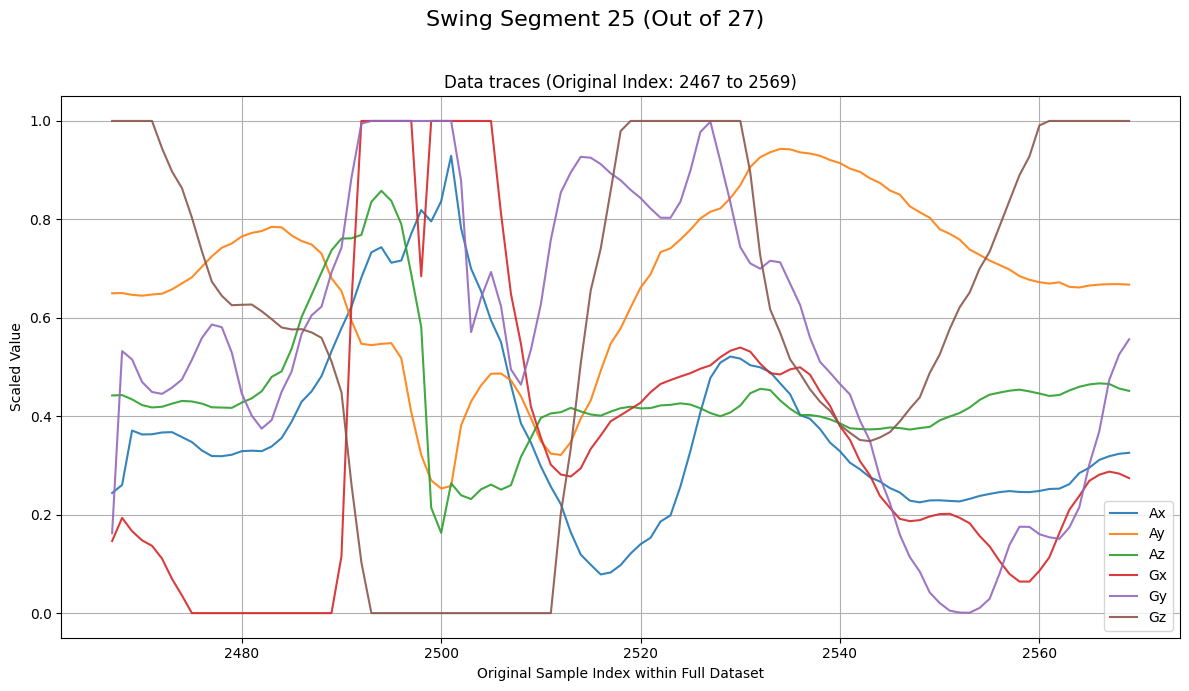

Plotted segment 25. Close plot window to see the next one (if applicable).


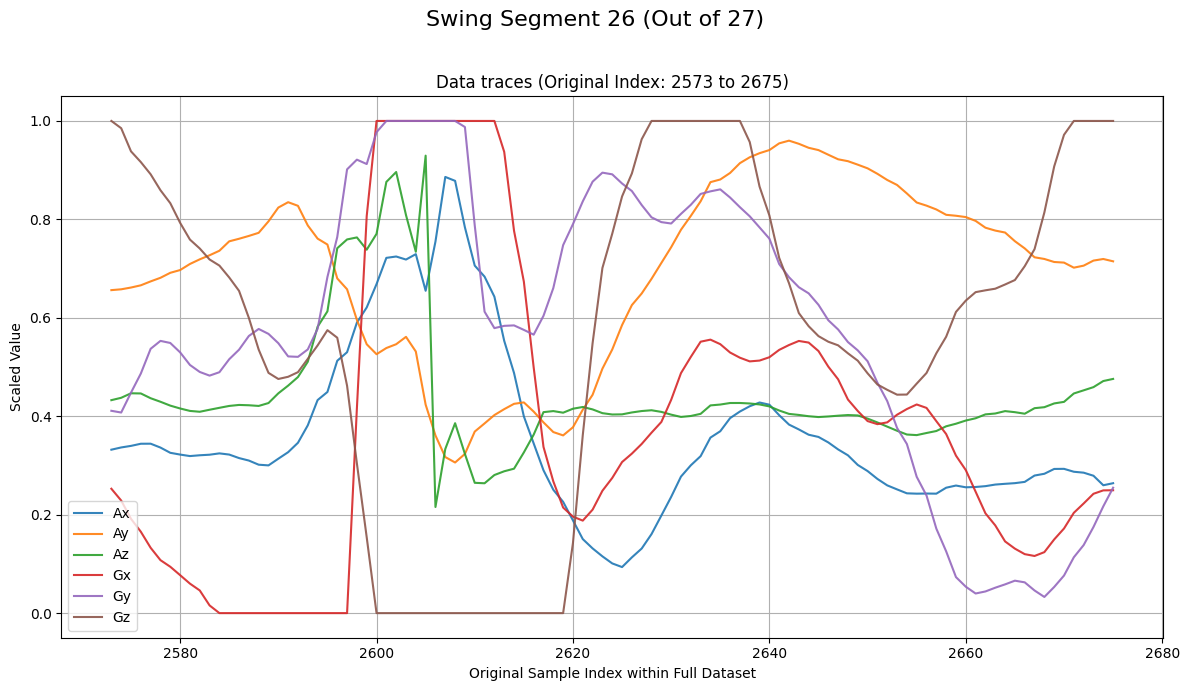

Plotted segment 26. Close plot window to see the next one (if applicable).


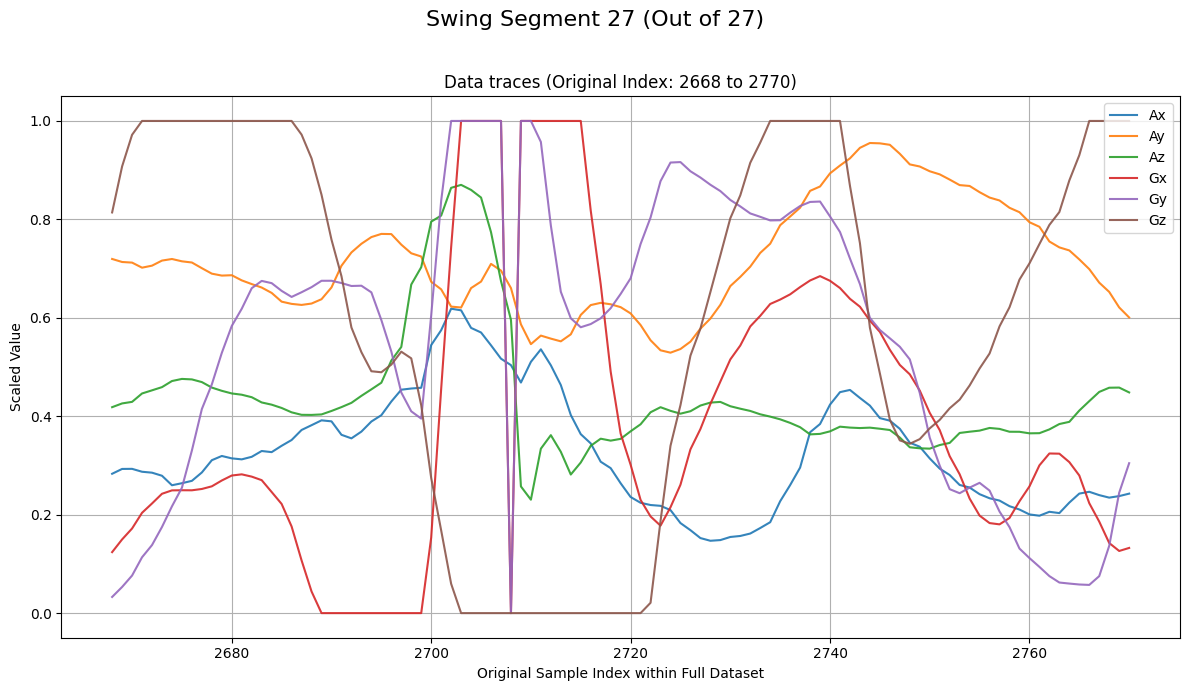


Finished processing. Found 27 swing segments.


In [12]:
# (Keep all the previous function definitions:
#  load_and_prepare_signal, detect_swing_peaks, segment_data_around_peaks, plot_segmentation_results)

def plot_individual_swing_segments(list_of_swing_dfs, original_df_columns):
    """
    Plots each swing segment DataFrame individually.

    Args:
        list_of_swing_dfs (list): A list of DataFrames, where each DataFrame is a swing segment.
        original_df_columns (pd.Index): The column names from the original DataFrame,
                                        to ensure consistent plotting if some segments
                                        are empty or have different structures (less likely with .copy()).
    """
    if not list_of_swing_dfs:
        print("No swing segments to plot individually.")
        return

    num_segments = len(list_of_swing_dfs)
    print(f"\nGenerating individual plots for {num_segments} swing segments...")

    for i, df_segment in enumerate(list_of_swing_dfs):
        if df_segment.empty:
            print(f"Segment {i+1} is empty, skipping plot.")
            continue

        plt.figure(figsize=(12, 7)) # You can adjust the figure size
        plt.suptitle(f"Swing Segment {i+1} (Out of {num_segments})", fontsize=16)
        
        # Number of columns to plot (can be all or a selection)
        # For this example, we plot all columns present in the segment
        columns_to_plot = df_segment.columns
        
        # Create a subplot for each column or plot all on one with legends
        # Plotting all on one y-axis might be cluttered if scales differ greatly.
        # Here, we'll plot them on the same axes but ensure legends are clear.
        
        ax = plt.gca() # Get current axes
        for col in columns_to_plot:
            if pd.api.types.is_numeric_dtype(df_segment[col]): # Only plot numeric columns
                # Using the segment's own index for the x-axis
                ax.plot(df_segment.index, df_segment[col], label=col, alpha=0.9)
            else:
                print(f"Skipping non-numeric column '{col}' in segment {i+1}.")

        ax.set_title(f"Data traces (Original Index: {df_segment.index[0]} to {df_segment.index[-1]})")
        ax.set_xlabel("Original Sample Index within Full Dataset")
        ax.set_ylabel("Scaled Value")
        ax.legend()
        ax.grid(True)
        
        plt.tight_layout(rect=[0, 0, 1, 0.96]) # Adjust layout to make space for suptitle
        
        # Note: This will show plots one by one if not in an interactive environment
        # that stacks them (like Jupyter). For many plots, you might want to save them.
        # Example: plt.savefig(f"swing_segment_{i+1}.png")
        plt.show()
        
        if i < num_segments - 1: # Optional: A small pause or message
             print(f"Plotted segment {i+1}. Close plot window to see the next one (if applicable).")

# --- Main Execution ---
if __name__ == "__main__":
    # **IMPORTANT**: Load your 'scaled_data' DataFrame here first!
    # Example:
    # scaled_data = pd.read_csv('path_to_your_data.csv')
    #
    # For demonstration, I'll re-create a dummy 'scaled_data' DataFrame.
    # Replace this with your actual data loading.
    scaled_data = scaled_df
    if 'scaled_data' not in locals() or not isinstance(scaled_data, pd.DataFrame):
        print("Dummy 'scaled_data' DataFrame creation for demonstration.")
        print("Please replace this with your actual data loading.")
        TARGET_COLUMN_NAME = 'Ax' # Defined at the top of the script
        EXPECTED_NUM_SWINGS = 27   # Defined at the top of the script
        fs = 100 # Sampling frequency
        duration_per_swing = 1.0 # seconds
        total_duration = EXPECTED_NUM_SWINGS * duration_per_swing
        time_vec = np.linspace(0, total_duration, int(total_duration * fs), endpoint=False)
        dummy_ax_signal = np.zeros_like(time_vec)
        for i in range(EXPECTED_NUM_SWINGS):
            peak_time = (i + 0.5) * duration_per_swing
            peak_idx = np.argmin(np.abs(time_vec - peak_time))
            pulse_width_samples = int(0.3 * fs)
            start_pulse = max(0, peak_idx - pulse_width_samples // 2)
            end_pulse = min(len(dummy_ax_signal), peak_idx + pulse_width_samples // 2)
            amplitude = 3 + 2 * np.sin(i * np.pi / 5) # Varying amplitude
            dummy_ax_signal[start_pulse:end_pulse] += amplitude * np.sin(np.pi * (time_vec[start_pulse:end_pulse] - time_vec[start_pulse]) / (time_vec[end_pulse-1] - time_vec[start_pulse]))
        dummy_ax_signal += np.random.normal(0, 0.5, len(dummy_ax_signal))
        scaled_data = pd.DataFrame({
            TARGET_COLUMN_NAME: dummy_ax_signal,
            'Ay': np.random.randn(len(dummy_ax_signal)) * 2,
            'Az': np.random.randn(len(dummy_ax_signal)) * 1.5
        })
        print(f"Dummy '{TARGET_COLUMN_NAME}' signal created with {EXPECTED_NUM_SWINGS} intended peaks.")

    # 1. Load and Prepare Data
    ax_signal, R_time_index = load_and_prepare_signal(scaled_data, TARGET_COLUMN_NAME)

    if ax_signal is not None:
        # 2. Detect Peaks
        R_peak_indices = detect_swing_peaks(ax_signal, EXPECTED_NUM_SWINGS, TARGET_COLUMN_NAME)

        # 3. Segment Data
        R_list_of_swing_dataframes = segment_data_around_peaks(scaled_data, R_peak_indices, EXPECTED_NUM_SWINGS)

        # 4. Plot Overall Segmentation Results
        plot_segmentation_results(ax_signal, R_time_index, R_peak_indices, R_list_of_swing_dataframes, TARGET_COLUMN_NAME)

        # 5. Plot Individual Swing Segments <<< --- NEW CALL --- >>>
        if R_list_of_swing_dataframes: # Check if the list is not empty
            plot_individual_swing_segments(R_list_of_swing_dataframes, scaled_data.columns)
        else:
            print("\nNo individual swing segments to plot as the list is empty.")


        if R_list_of_swing_dataframes:
            print(f"\nFinished processing. Found {len(R_list_of_swing_dataframes)} swing segments.")
        else:
            print("\nNo swing segments were created.")
    else:
        print("Could not proceed due to issues loading the signal.")